# Duelling Deep Q-Network CNN implementation 


In [1]:
import sys, os
# if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
!wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
!wget -q https://raw.githubusercontent.com/laktionov/RL-course/pmi_movs_2024/hw2/atari_wrappers.py
!wget -q https://raw.githubusercontent.com/laktionov/RL-course/pmi_movs_2024/hw2/utils.py
!wget -q https://raw.githubusercontent.com/laktionov/RL-course/pmi_movs_2024/hw2/framebuffer.py
!wget -q https://raw.githubusercontent.com/laktionov/RL-course/pmi_movs_2024/hw2/prioritized_sampler.py

!pip -q install gymnasium[atari,accept-rom-license]

!touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

(Reading database ... 113807 files and directories currently installed.)
Preparing to unpack .../xserver-common_2%3a1.20.13-1ubuntu1~20.04.15_all.deb ...
Unpacking xserver-common (2:1.20.13-1ubuntu1~20.04.15) over (2:1.20.13-1ubuntu1~20.04.14) ...
Preparing to unpack .../xvfb_2%3a1.20.13-1ubuntu1~20.04.15_amd64.deb ...
Unpacking xvfb (2:1.20.13-1ubuntu1~20.04.15) over (2:1.20.13-1ubuntu1~20.04.14) ...
Setting up xserver-common (2:1.20.13-1ubuntu1~20.04.15) ...
Setting up xvfb (2:1.20.13-1ubuntu1~20.04.15) ...
Processing triggers for man-db (2.9.1-1) ...
bash: line 9: gdown: command not found
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kaggle-environments 1.14.3 requires shimmy>=1.2.1, but you have shimmy 0.2.1 which is incompatible.
Starting virtual X frame buffer: Xvfb.


In [2]:
%load_ext autoreload
%autoreload 2

We are using the latest version of Gymnasium

In [4]:
import gymnasium as gym
import random
import numpy as np
import utils
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image


In [5]:
ENV_NAME = "BreakoutNoFrameskip-v4"

# Preprocessing

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
/opt/conda/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


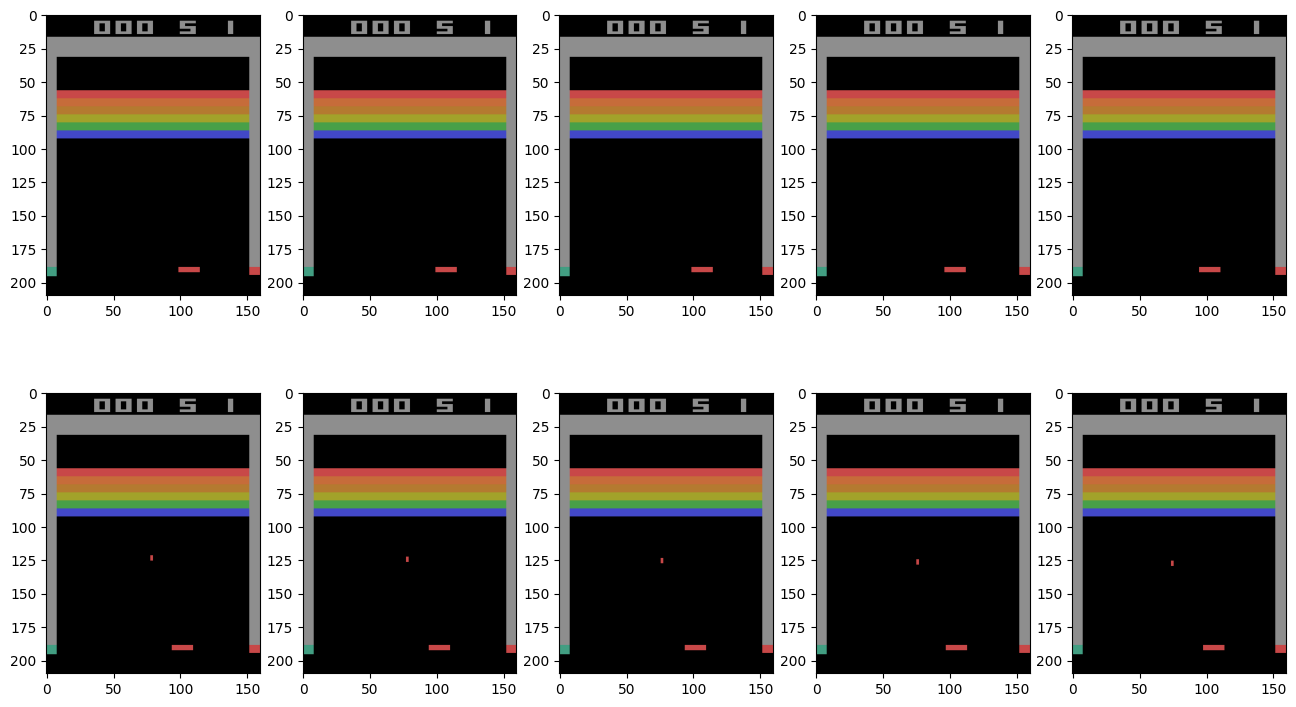

In [6]:
env = gym.make(ENV_NAME, render_mode="rgb_array")
env.reset()

n_cols = 5
n_rows = 2
fig = plt.figure(figsize=(16, 9))

for row in range(n_rows):
    for col in range(n_cols):
        ax = fig.add_subplot(n_rows, n_cols, row * n_cols + col + 1)
        ax.imshow(env.render())
        obs, _, _, _, _ = env.step(env.action_space.sample())
plt.show()

In [7]:
from gymnasium import ObservationWrapper
from gymnasium.spaces import Box


class PreprocessAtariObs(ObservationWrapper):
    def __init__(self, env):
        """A gym wrapper that crops, scales image into the desired shapes and grayscales it."""
        ObservationWrapper.__init__(self, env)

        self.img_size = (1, 64, 64)
        self.observation_space = Box(0.0, 1.0, self.img_size)


    def _to_gray_scale(self, img, channel_weights=[0.8, 0.1, 0.1]):
      red, green, blue = img[:,:,0], img[:,:,1], img[:,:,2]
      obs = channel_weights[0] * red + channel_weights[1] * green + channel_weights[2] * blue
      return obs

    def observation(self, img):
        """what happens to each observation"""
        # Here's what you need to do:
        #  * crop image, remove irrelevant parts
        #  * resize image to self.img_size
        #     (use imresize from any library you want,
        #      e.g. opencv, skimage, PIL, keras)
        #  * cast image to grayscale
        #  * convert image pixels to (0,1) range, float32 type


        PIL_img = Image.fromarray(img.astype('uint8'), 'RGB')
        #  * crop image, remove irrelevant parts
        area = (8, 32, 152, 200)
        cropped_img = PIL_img.crop(area)

        #  * resize image to self.img_size
        res_img = cropped_img.resize((64, 64))

        #  * cast image to grayscale
        gray_image = self._to_gray_scale(np.array(res_img))

        #  * convert image pixels to (0,1) range, float32 type
        gray_image = gray_image/255

        image = gray_image.astype(np.float32)
        image = np.expand_dims(image, axis=0)

        return image

# Wrapping

In [8]:
import atari_wrappers

def PrimaryAtariWrap(env, clip_rewards=True):
    assert 'NoFrameskip' in env.spec.id

    # This wrapper holds the same action for <skip> frames and outputs
    # the maximal pixel value of 2 last frames (to handle blinking
    # in some envs)
    env = atari_wrappers.MaxAndSkipEnv(env, skip=4)

    # This wrapper sends done=True when each life is lost
    # (not all the 5 lives that are givern by the game rules).
    # It should make easier for the agent to understand that losing is bad.
    env = atari_wrappers.EpisodicLifeEnv(env)

    # This wrapper laucnhes the ball when an episode starts.
    # Without it the agent has to learn this action, too.
    # Actually it can but learning would take longer.
    env = atari_wrappers.FireResetEnv(env)

    # This wrapper transforms rewards to {-1, 0, 1} according to their sign
    if clip_rewards:
        env = atari_wrappers.ClipRewardEnv(env)

    # This wrapper is yours :)
    env = PreprocessAtariObs(env)
    return env

# Frame Buffer



In [9]:
from framebuffer import FrameBuffer

def make_env(clip_rewards=True, seed=None):
    env = gym.make(ENV_NAME, render_mode="rgb_array")  # create raw env
    if seed is not None:
        env.seed(seed)
    env = PrimaryAtariWrap(env, clip_rewards)
    env = FrameBuffer(env, n_frames=4, dim_order='pytorch')
    return env

env = make_env()
env.reset()
n_actions = env.action_space.n
state_shape = env.observation_space.shape
n_actions, state_shape

(4, (4, 64, 64))

# DQN as it is

In [10]:

import torch
import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# those who have a GPU but feel unfair to use it can uncomment:
# device = torch.device('cpu')
device

device(type='cuda')

In [11]:
def conv2d_size_out(size, kernel_size, stride):
    """
    common use case:
    cur_layer_img_w = conv2d_size_out(cur_layer_img_w, kernel_size, stride)
    cur_layer_img_h = conv2d_size_out(cur_layer_img_h, kernel_size, stride)
    to understand the shape for dense layer's input
    """
    return (size - (kernel_size - 1) - 1) // stride  + 1

In [41]:
# Единственная измененная функция
class DQNAgent(nn.Module):
    def __init__(self, state_shape, n_actions, epsilon=0):

        super().__init__()
        self.epsilon = epsilon
        self.n_actions = n_actions
        self.state_shape = state_shape

        # Define your network body here. Please make sure agent is fully contained here
        self.layer1 = nn.Sequential(nn.Conv2d(4, 16, kernel_size=(3,3), stride=2), nn.ReLU(),
                                    nn.Conv2d(16, 32, kernel_size=(3,3), stride=2), nn.ReLU(), 
                                    nn.Conv2d(32, 64, kernel_size=(3,3), stride=2), nn.ReLU(), 
                                   )
  
        self.layer_value =  nn.Sequential(nn.Linear(3136, 256), nn.ReLU(), 
                                          nn.Linear(256, 1))
    
        self.layer_advantage = nn.Sequential(nn.Linear(3136, 256), nn.ReLU(), 
                                          nn.Linear(256, n_actions)) 




    def forward(self, state_t):
        """
        takes agent's observation (tensor), returns qvalues (tensor)
        :param state_t: a batch of 4-frame buffers, shape = [batch_size, 4, h, w]
        """
        # Use your network to compute qvalues for given state
        x = self.layer1(state_t).flatten(start_dim=1)
        
        
        advantage = self.layer_advantage(x)
        
        values = self.layer_value(x)
        
        qvalues = values + (advantage - torch.mean(advantage))

        
        assert len(
            qvalues.shape) == 2 and qvalues.shape[0] == state_t.shape[0] and qvalues.shape[1] == n_actions

        return qvalues

    def get_qvalues(self, states):
        """
        like forward, but works on numpy arrays, not tensors
        """
        model_device = next(self.parameters()).device
        states = torch.tensor(states, device=model_device, dtype=torch.float)
        qvalues = self.forward(states.to(device=device))
        return qvalues.data.cpu().numpy()

    def sample_actions(self, qvalues):
        """pick actions given qvalues. Uses epsilon-greedy exploration strategy. """
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape

        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)

        should_explore = np.random.choice(
            [0, 1], batch_size, p=[1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)

In [42]:
agent = DQNAgent(state_shape, n_actions, epsilon=0.5).to(device)

Now let's try out our agent to see if it raises any errors.

In [43]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    for _ in range(n_games):
        s, _ = env.reset()
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, terminated, truncated, _ = env.step(action)
            reward += r
            if terminated or truncated:
                break

        rewards.append(reward)
    return np.mean(rewards)

# Experience Replay


In [44]:
import random


In [45]:
class ReplayBuffer(object):
    def __init__(self, size):
        """
        Create Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.

        Note: for this assignment you can pick any data structure you want.
              If you want to keep it simple, you can store a list of tuples of (s, a, r, s') in self._storage
              However you may find out there are faster and/or more memory-efficient ways to do so.
        """
        self._storage = []
        self._maxsize = size

        # OPTIONAL: YOUR CODE

    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        '''
        Make sure, _storage will not exceed _maxsize.
        Make sure, FIFO rule is being followed: the oldest examples has to be removed earlier
        '''
        data = (obs_t, action, reward, obs_tp1, done)
        storage = self._storage
        maxsize = self._maxsize
            # add data to storage
        if len(self._storage) < maxsize:
          self._storage.append(data)
        else:
          self._storage.pop(0)
          self._storage.append(data)


    def sample(self, batch_size):
        """Sample a batch of experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        """
        storage = self._storage
        # <YOUR CODE>
            # randomly generate batch_size integers
            # to be used as indexes of samples
        sample = random.sample(storage, batch_size)
        obs_batch = np.zeros((batch_size, np.shape(sample[0][0])[0], np.shape(sample[0][0])[1], np.shape(sample[0][0])[2]))
        act_batch = np.zeros(batch_size, dtype = np.int8) # Actions is some kind of int from 0,1,2
        rew_batch = np.zeros(batch_size, dtype = np.int32) # Reward is int from atari page
        next_obs_batch = np.zeros((batch_size, np.shape(sample[0][0])[0], np.shape(sample[0][0])[1], np.shape(sample[0][0])[2]))
        done_mask = np.zeros(batch_size, dtype = np.bool_) #either 0 or 1, so it makes sense to choose bool
        # <YOUR CODE>
            # collect <s,a,r,s',done> for each index
        for i in range(batch_size):

          obs_batch[i] = sample[i][0]
          act_batch[i] = sample[i][1]
          rew_batch[i] = sample[i][2]
          next_obs_batch[i] = sample[i][3]
          done_mask[i] = sample[i][4]

        return obs_batch, act_batch, rew_batch, next_obs_batch, done_mask

            # <states>, <actions>, <rewards>, <next_states>, <is_done>

In [46]:
exp_replay = ReplayBuffer(10)

for _ in range(30):
    exp_replay.add(env.reset()[0], env.action_space.sample(),
                   1.0, env.reset()[0], done=False)

obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(
    5)

assert len(exp_replay) == 10, "experience replay size should be 10 because that's what maximum capacity is"

In [47]:
def play_and_record(initial_state, agent, env, exp_replay, n_steps=1):
    """
    Play the game for exactly n steps, record every (s,a,r,s', done) to replay buffer.
    Whenever game ends, add record with done=True and reset the game.
    It is guaranteed that env has done=False when passed to this function.

    PLEASE DO NOT RESET ENV UNLESS IT IS "DONE"

    :returns: return sum of rewards over time and the state in which the env stays
    """
    s = initial_state
    if len(np.shape(s)) != 4:
      s = np.expand_dims(s, axis=0)
    sum_rewards = 0


    # Play the game for n_steps as per instructions above
    for _ in range(n_steps):
      q_value = agent.get_qvalues(s)
      action = agent.sample_actions(q_value)[0]
      obs, rew, done, _, _ = env.step(action)


      exp_replay.add(np.squeeze(s, axis=0), action, rew, obs, done)



      s = obs
      s = np.expand_dims(s, axis=0)
      sum_rewards += rew

      if done == True:
        s, _ = env.reset()
        if len(np.shape(s)) != 4:
          s = np.expand_dims(s, axis=0)


    return sum_rewards, s



In [48]:
# testing your code.
exp_replay = ReplayBuffer(2000)

state, _ = env.reset()
play_and_record(state, agent, env, exp_replay, n_steps=1000)

# if you're using your own experience replay buffer, some of those tests may need correction.
# just make sure you know what your code does
assert len(exp_replay) == 1000, "play_and_record should have added exactly 1000 steps, "\
                                 "but instead added %i" % len(exp_replay)
is_dones = list(zip(*exp_replay._storage))[-1]

assert 0 < np.mean(is_dones) < 0.1, "Please make sure you restart the game whenever it is 'done' and record the is_done correctly into the buffer."\
                                    "Got %f is_done rate over %i steps. [If you think it's your tough luck, just re-run the test]" % (
                                        np.mean(is_dones), len(exp_replay))

for _ in range(100):
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(10)
    assert obs_batch.shape == next_obs_batch.shape == (10,) + state_shape
    assert act_batch.shape == (10,), "actions batch should have shape (10,) but is instead %s" % str(act_batch.shape)
    assert reward_batch.shape == (10,), "rewards batch should have shape (10,) but is instead %s" % str(reward_batch.shape)
    assert is_done_batch.shape == (10,), "is_done batch should have shape (10,) but is instead %s" % str(is_done_batch.shape)
    assert [int(i) in (0, 1)
            for i in is_dones], "is_done should be strictly True or False"
    assert [0 <= a < n_actions for a in act_batch], "actions should be within [0, n_actions)"

print("Well done!")

Well done!


# Target networks



In [49]:
target_network = DQNAgent(agent.state_shape, agent.n_actions, epsilon=0.5).to(device)
# This is how you can load weights from agent into target network
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

# Learning with... Q-learning

In [50]:
def compute_td_loss(states, actions, rewards, next_states, is_done,
                    agent, target_network,
                    gamma=0.99,
                    check_shapes=False,
                    device=device):
    """ Compute td loss using torch operations only. Use the formulae above. """
    states = torch.tensor(states, device=device, dtype=torch.float)    # shape: [batch_size, *state_shape]

    # for some torch reason should not make actions a tensor
    actions = torch.tensor(actions, device=device, dtype=torch.long)    # shape: [batch_size]
    rewards = torch.tensor(rewards, device=device, dtype=torch.float)  # shape: [batch_size]
    # shape: [batch_size, *state_shape]
    next_states = torch.tensor(next_states, device=device, dtype=torch.float)
    is_done = torch.tensor(
        is_done.astype('float32'),
        device=device,
        dtype=torch.float
    )  # shape: [batch_size]
    is_not_done = 1 - is_done

    # get q-values for all actions in current states
    predicted_qvalues = agent(states)
    assert predicted_qvalues.requires_grad, "qvalues must be a torch tensor with grad"

    # compute q-values for all actions in next states
    with torch.no_grad():
        predicted_next_qvalues = target_network(next_states)

    # select q-values for chosen actions
    predicted_qvalues_for_actions = predicted_qvalues[
      range(states.shape[0]), actions
    ]

    # compute V*(next_states) using predicted next q-values
    next_state_values = torch.max(predicted_next_qvalues, dim=1).values

    assert next_state_values.dim() == 1 and next_state_values.shape[0] == states.shape[0], "must predict one value per state"

    # compute "target q-values" for loss - it's what's inside square parentheses in the above formula.
    # at the last state use the simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
    # you can multiply next state values by is_not_done to achieve this.
    target_qvalues_for_actions = rewards + gamma * is_not_done * next_state_values

    assert target_qvalues_for_actions.requires_grad == False, "do not send gradients to target!"

    # mean squared error loss to minimize
    loss = torch.mean((predicted_qvalues_for_actions - target_qvalues_for_actions)**2)

    if check_shapes:
        assert predicted_next_qvalues.data.dim() == 2, "make sure you predicted q-values for all actions in next state"
        assert next_state_values.data.dim() == 1, "make sure you computed V(s') as maximum over just the actions axis and not all axes"
        assert target_qvalues_for_actions.data.dim() == 1, "there's something wrong with target q-values, they must be a vector"

    return loss

Sanity checks

In [51]:
obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(10)

loss = compute_td_loss(obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch,
                       agent, target_network,
                       gamma=0.99, check_shapes=True)
loss.backward()

assert loss.requires_grad and tuple(loss.data.size()) == (), "you must return scalar loss - mean over batch"
assert np.any(next(agent.parameters()).grad.data.cpu().numpy() != 0), "loss must be differentiable w.r.t. network weights"
assert np.all(next(target_network.parameters()).grad is None), "target network should not have grads"

In [52]:
obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(
    10)

loss = compute_td_loss(obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch,
                       agent, target_network,
                       gamma=0.99, check_shapes=True)
loss.backward()

assert loss.requires_grad and tuple(loss.data.size()) == (
    ), "you must return scalar loss - mean over batch"
assert np.any(next(agent.parameters()).grad.data.cpu().numpy() !=
              0), "loss must be differentiable w.r.t. network weights"
assert np.all(next(target_network.parameters()).grad is None), "target network should not have grads"

# Main loop

It's time to put everything together and see if it learns anything.

In [53]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [54]:
seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [55]:
env = make_env(seed)
state_shape = env.observation_space.shape
n_actions = env.action_space.n
state, _ = env.reset()

agent = DQNAgent(state_shape, n_actions, epsilon=1).to(device)
target_network = DQNAgent(state_shape, n_actions).to(device)
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

Buffer of size $10^4$ fits into 5 Gb RAM.

Larger sizes ($10^5$ and $10^6$ are common) can be used. It can improve the learning, but $10^4$ is quiet enough. $10^2$ will probably fail learning.

In [56]:
exp_replay = ReplayBuffer(10**4)
for i in range(100):
    if not utils.is_enough_ram(min_available_gb=0.1):
        print("""
            Less than 100 Mb RAM available.
            Make sure the buffer size in not too huge.
            Also check, maybe other processes consume RAM heavily.
            """)
        break
    play_and_record(state, agent, env, exp_replay, n_steps=10**2)
    if len(exp_replay) == 10**4:
        break
print(len(exp_replay))

10000


In [57]:
import pickle


In [58]:
timesteps_per_epoch = 1
batch_size = 32
total_steps = 3 * 10**6
decay_steps = 10**6

opt = torch.optim.Adam(agent.parameters(), lr=1e-4)

init_epsilon = 1
final_epsilon = 0.1

loss_freq = 50
refresh_target_network_freq = 5000
eval_freq = 5000

max_grad_norm = 50

n_lives = 5

In [59]:
mean_rw_history = []
td_loss_history = []
grad_norm_history = []
initial_state_v_history = []

buffer size = 10000, epsilon = 0.50050


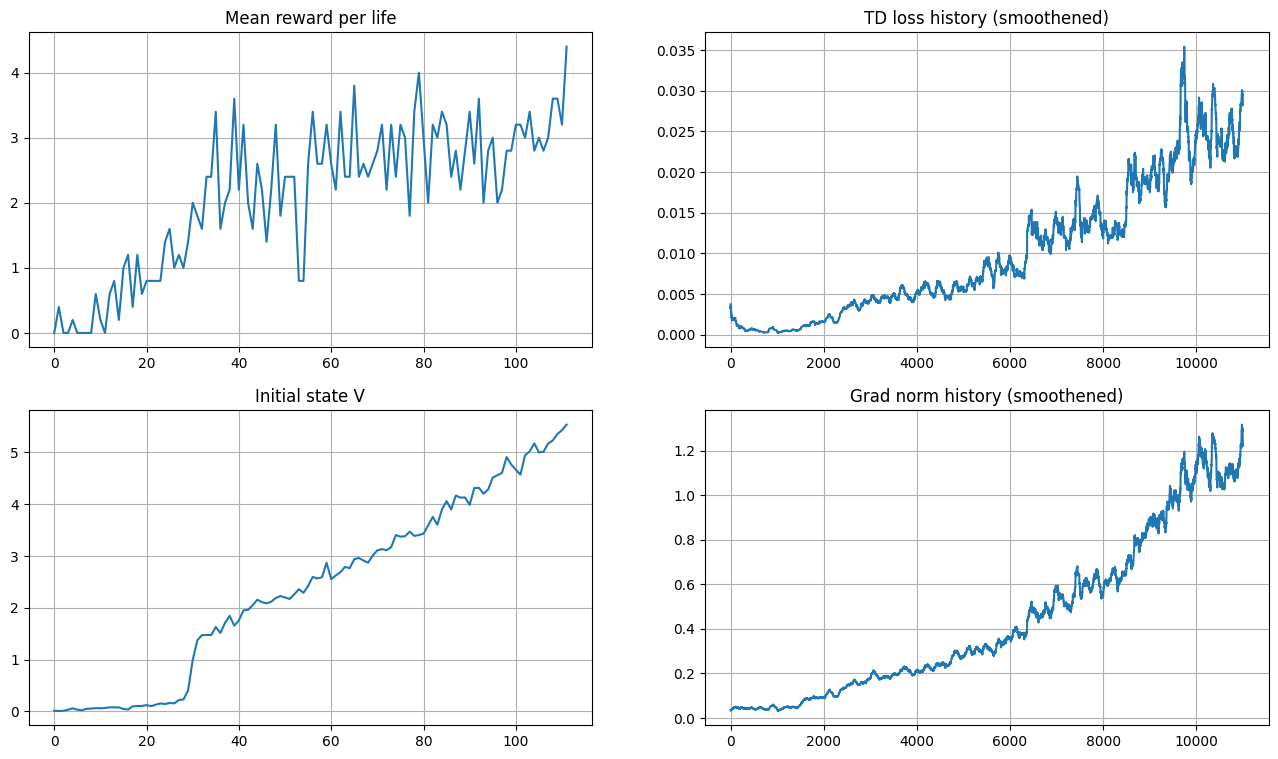

 18%|█▊        | 555000/3000001 [2:20:39<10:19:37, 65.77it/s]


NameError: name 'save_object' is not defined

In [61]:
state, _ = env.reset()
for step in trange(total_steps + 1):
    if not utils.is_enough_ram():
        print('less that 100 Mb RAM available, freezing')
        print('make sure everything is ok and make KeyboardInterrupt to continue')
        try:
            while True:
                pass
        except KeyboardInterrupt:
            pass

    agent.epsilon = utils.linear_decay(init_epsilon, final_epsilon, step, decay_steps)

    # play
    _, state = play_and_record(state, agent, env, exp_replay, timesteps_per_epoch)

    # train
    # < sample batch_size of data from experience replay >
    states, actions, rewards, next_states, is_done = exp_replay.sample(batch_size)

    # loss = < compute TD loss >
    loss = compute_td_loss(states, actions, rewards, next_states, is_done,
                    agent, target_network,
                    gamma=0.99,
                    check_shapes=False,
                    device=device)

    loss.backward()
    grad_norm = nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm)
    opt.step()
    opt.zero_grad()

    if step % loss_freq == 0:
        td_loss_history.append(loss.data.cpu().item())
        grad_norm_history.append(grad_norm.cpu().item())

    if step % refresh_target_network_freq == 0:
        # Load agent weights into target_network
        target_network.load_state_dict(agent.state_dict())

    if step % eval_freq == 0:
        mean_rw_history.append(evaluate(
            make_env(clip_rewards=True, seed=step), agent, n_games=3 * n_lives, greedy=True)
        )
        initial_state_q_values = agent.get_qvalues(
            [make_env(seed=step).reset()[0]]
        )
        initial_state_v_history.append(np.max(initial_state_q_values))

        clear_output(True)
        print("buffer size = %i, epsilon = %.5f" %
              (len(exp_replay), agent.epsilon))

        plt.figure(figsize=[16, 9])

        plt.subplot(2, 2, 1)
        plt.title("Mean reward per life")
        plt.plot(mean_rw_history)
        plt.grid()

        assert not np.isnan(td_loss_history[-1])
        plt.subplot(2, 2, 2)
        plt.title("TD loss history (smoothened)")
        plt.plot(utils.smoothen(td_loss_history))
        plt.grid()

        plt.subplot(2, 2, 3)
        plt.title("Initial state V")
        plt.plot(initial_state_v_history)
        plt.grid()

        plt.subplot(2, 2, 4)
        plt.title("Grad norm history (smoothened)")
        plt.plot(utils.smoothen(grad_norm_history))
        plt.grid()

        plt.show()
    if mean_rw_history[-1] > 4:
        torch.save(target_network.state_dict(), 'Duelling_target_network.pth' )
        torch.save(agent.state_dict(), 'Duelling_agent.pth')
        save_object(exp_replay, 'Duelling_exp_replay.pkl')

        break

In [62]:
import pickle
def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)
        

In [63]:
save_object(exp_replay, 'Duelling_exp_replay.pkl')


In [64]:
final_score = evaluate(
  make_env(clip_rewards=False, seed=9),
    agent, n_games=30, greedy=True, t_max=10 * 1000
) * n_lives
print('final score:', final_score)
assert final_score > 15, 'not as cool as DQN can'
print('Cool!')

final score: 28.0
Cool!
